# Telco Classification Project

![](telco_churn_pic.png)

In [1]:
from scipy import stats

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import os

import graphviz
from graphviz import Graph

import env
from acquire_telco import get_telco_data, summarize_telco
from prepare_telco import clean_telco, remove_unwanted_values, train_validate_test_split, num_distributions
from helper import splitting_target_var, get_final_report, pred_proba, make_predictions
from telco_model import baseline_acc, rand_forest, knneighbors, tree_model
from model_report import model_report
import explore

import warnings
warnings.filterwarnings("ignore")

## Planning

- Make a README.md that will hold all of the project details including a data dictionary, key finding, initial hypotheses, and explain how my process can be replicated
- Create a MVP, originally and work through the iterative process of making improvements to that MVP.
- Define atleast 2 clear sets of null and alternative hypotheses set an alpha value.
- Create two .py scripts for both acquire and prepare, in order to automate the collection and cleaning of the data.
- Create a helper.py for any other functions I need implamented thoughout the pipeline.
- Properly anotate my code as I run though the process, in order for the code to be easily understood, and document any decisions that were made when cleaning, creating new columns, or removing rows of data.

### Data Science Pipeline
##### Acquire
- Create an acquire.py (acquire_telco.py) was the name of my py file.
- Use that acquire_telco.py file to grab the data from the CodeUp SQL database and cache that file to a csv for ease of accessability.
- Render the csv into a pandas dataframe on python.
- Summarize the initial data and plot the distributions of individual variables.
##### Prepare
- Create a prepare.py (prepare_telco.py) was the name of my py file.
- Clean the data as I see fit, handling the missing values and encoding values as necessary in order to give numeric values that will work with the models
- There were 11 values with no current tenure, and I made the decision to remove those values. These customers have not payed their first bill, so there is no data on weather they are satisfied with the product.
- Add new columns that might be useful in modeling, might need more information from the explore for incite into columns that once combined will drive churn.
- I added two new columns (auto_pay - if payment type was automatic.),and (add_ons - A column that sums the six aditional services.)
##### Explore
- Awnser my initial hypotheses that was asked in my planning phase, and test those hypotheses using statistical tests, either accepting or rejecting the null hypothesis.
- Continue using statistical testing and visualizations to discover variable relationships in the data, and attempt to understand "how the data works".
- Summarize my conclusions giving clear awnsers to the questions I posed in the planning stage and summarize any takeaways that might be useful.
##### Modeling and Evaluation
- Train and evaluate multiple models comparing those models on different evaluation metrics.
- Validate the models and choose the best model that was found in the validation phase.
- Test the best model found and summarize the performance and document the results using a confusion matrix, predict methods, and classification reports.
- Save the test predictions to a .csv file.
##### Delivery
- Deliver my refined jupyter notebook to the CodeUp data science team.
- Summarize my findings, and build a narrative around the data, pulling from my knowledge on story telling.
- Walk though the notebook explaining finding, documentation, and decisions that were made.
- End with key takeaways and reccomendations.

### Modules

- acquire_telco.py Gathers the data from the SQL database and puts it into a pandas dataframe.
- prepare_telco.py Prepares my data for use.
- helper.py Contains oddball functions that are helpful in getting to deliverables.
- telco_model.py contains my different models, and contains the best metrics I found, but can be changed.
- model_report.py contains functions that allow me to create comprehensive model reports on the data.
- explore.py contains functions that assisted me in doing statistical analysis and visualization.

### Hypotheses

$H_O$ - 
$H_A$ - 

$H_O$ - Streaming television has no affect on the rates of churn
$H_A$ - Streaming television has an affect on the rates of churn

### EXECUTIVE SUMMARY

- 
- 
- 

### Data Dictionary

|Target|Datatype|Definition|
|:-------|:--------|:----------|
|churn|dtype('O')|Yes or no, if the customer churned|

|Feature|Datatype|Definition|
|:-------|:--------|:----------|
|customer_id| dtype('O')|Identification number for customer|
|gender| dtype('O')|Customer gender, male or female|
|senior_citizen| dtype('int64')|Yes or no, is the customer a senior citizen|
|partner| dtype('O')|Yes or no, does the customer customer has a parter|
|dependents| dtype('O')|Number of dependents a customer has|
|tenure| dtype('int64')|Number of months a customer has been with the company|
|phone_service| dtype('O')|Type of phone service plan a customer has|
|multiple_lines| dtype('O')|Yes or no, does the customer have multiple lines|
|internet_service_type_id| dtype('int64')|1 for DSL, 2 for Fiber Optic, 3 for None|
|online_security| dtype('O')|Yes, no, or no internet service|
|online_backup | dtype('O')|Yes, no, or no internet service|
|device_protection| dtype('O')|Yes, no, or no internet service|
|tech_support| dtype('O')|Yes, no, or no internet service|
|streaming_tv| dtype('O')|Yes, no, or no internet service|
|streaming_movies| dtype('O')|Yes, no, or no internet service|
|contract_type_id| dtype('int64')|1 for month-to-month, 2 for year, and 3 for two-year contract|
|paperless_billing| dtype('O')| Yes or no, whether or not the customer uses paperless billing|
|payment_type_id | dtype('int64')|1 for electronic check, 2 for mailed check, 3 for automatic bank transfer, 4 for automatic credit card payment|
|monthly_charges| dtype('float64')|Monthly charges the customer pays|
|total_charges| dtype('O')|Total charges the customer has paid|
|contract_type| dtype('O')|Month-to-month, year, or two-year contract|
|internet_service_type| dtype('O')|DSL, Fiber Optic, or None|
|payment_type| dtype('O')|Electronic check, mailed check, automatic bank transfer, or automatic credit card payment|

## Acquire

In [2]:
# Read the telco data into a pandas dataframe
df = get_telco_data()

In [3]:
# Summarize the dataframe
summarize_telco(df)

The Telco dataframe has a total of 28 columns and 7043 rows.
___________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7043 non-null   int64  
 1   customer_id                 7043 non-null   object 
 2   gender                      7043 non-null   object 
 3   senior_citizen              7043 non-null   int64  
 4   partner                     7043 non-null   object 
 5   dependents                  7043 non-null   object 
 6   tenure                      7043 non-null   int64  
 7   phone_service               7043 non-null   object 
 8   multiple_lines              7043 non-null   object 
 9   internet_service_type_id    7043 non-null   int64  
 10  online_security             7043 non-null   object 
 11  online_backup             

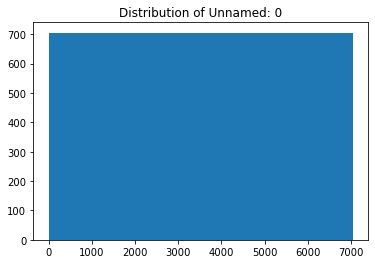

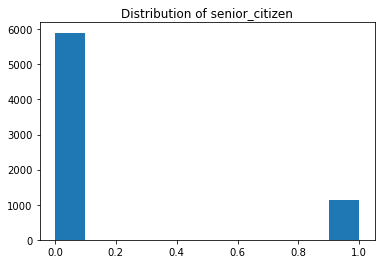

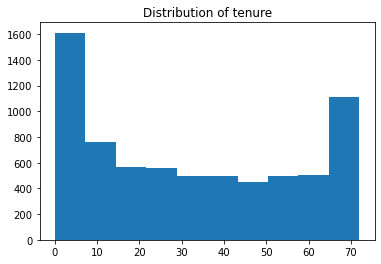

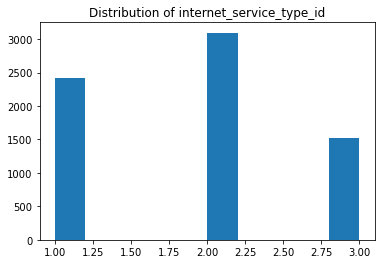

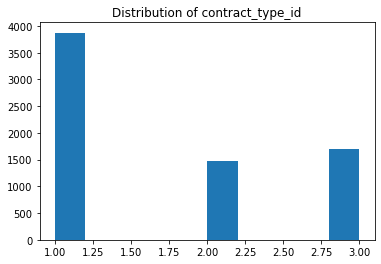

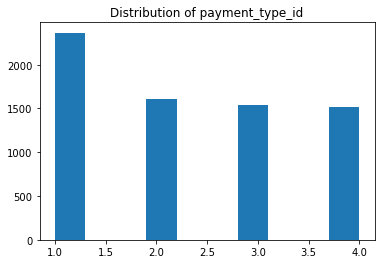

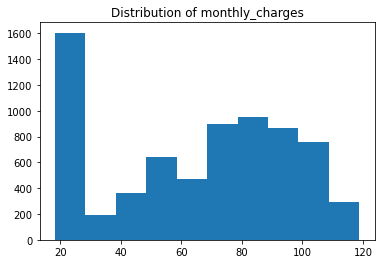

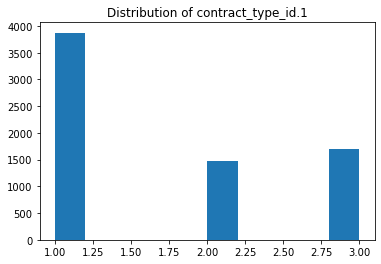

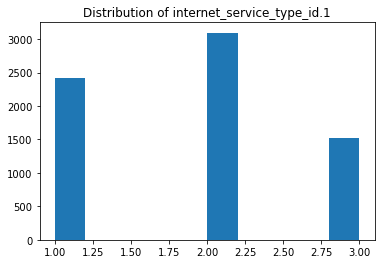

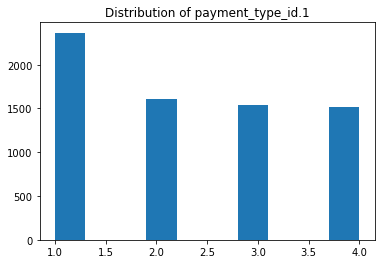

In [4]:
num_distributions(df)

### Acquire Takeaways
- I made the get_telco_data function that uses a SQL query to acquire my data from the Codeup database.
- Im bringing in 7043 rows and 28 columns after I joined the SQL tables together.
- The data has several types and will need alot of cleaning to get only numeric values.

## Prepare

I took the df and created numeric representations for the different values, I also added two columns (add_ons)
which takes a sum of the columns online_security, online_backup, device_protection, tech_support, streaming_tv,
and streaming_movies. I decided these were all additional services that customers opted into, and might be a driver of churn. My other column I added was (auto_pay) that took in the payment_type column and searched for the word "auto", and returns a boolean value.

In [5]:
df = clean_telco(df)

In [6]:
df.head(3)

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,payment_type_bank_transfer_(automatic),payment_type_credit_card_(automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_dsl,internet_service_type_fiber_optic,internet_service_type_none,contract_type_month-to-month,contract_type_one_year,contract_type_two_year
0,0,1,1,65,1,1,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
1,0,0,0,54,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0,0,0,56,0,0,1,1,1,1,...,1,0,0,0,1,0,0,0,0,1


My decision to remove the customers with no tenure was that they were not good representations of our overall dataset having been with Telco for under 1 month.

These customers were a small percentage of the overall dataframe making up ~.15% of the overall data

In [7]:
# Takes those with no tenure and removes the customers data from the df.
remove_unwanted_values(df)

In [8]:
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'auto_pay', 'add_ons', 'gender_female', 'gender_male',
       'payment_type_bank_transfer_(automatic)',
       'payment_type_credit_card_(automatic)', 'payment_type_electronic_check',
       'payment_type_mailed_check', 'internet_service_type_dsl',
       'internet_service_type_fiber_optic', 'internet_service_type_none',
       'contract_type_month-to-month', 'contract_type_one_year',
       'contract_type_two_year'],
      dtype='object')

In [9]:
# split the data into 3 groups, while stratifying for our target variable (churn)
train,validate,test = train_validate_test_split(df,target = "churn", seed = 174)

In [10]:
print(f"Train {train.shape}, Validate {validate.shape},Test {test.shape}")

Train (3937, 30), Validate (1688, 30),Test (1407, 30)


## Explore

In [11]:
additionals = ['online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
cat_vars = ["auto_pay","partner","add_ons","tech_support","online_security","senior_citizen","payment_type_electronic_check","internet_service_type_fiber_optic","streaming_tv","streaming_movies"]
quant_vars = ["monthly_charges","total_charges"]

It seems that those that have streaming services seem to churn more then what is normally seen, which might be indicating a lackluster set of streaming options or customer dissatisfaction with these services.

In [12]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_tv')

streaming_tv 
_____________________



TypeError: 'module' object is not callable

In [13]:
explore.explore_bivariate_categorical(train,target = "churn",cat_var = 'streaming_movies')

streaming_movies 
_____________________



TypeError: 'module' object is not callable

In [14]:
explore.telco_churn_heatmap(df)

TypeError: 'module' object is not callable

In [ ]:
explore.plot_all_continuous_vars(train,target = "churn",quant_vars = quant_vars)

In [ ]:
explore.plot_violin_grid_with_color(train,target = "churn", cat_vars = cat_vars,quant_vars = quant_vars)

## Modeling and evaluation

I made a function that removes churn from our train validate and test, saving each as there respecting y value.

In [15]:
X_train,y_train,X_validate,y_validate,X_test,y_test  = splitting_target_var(train,validate,test)

In [16]:
X_train.shape,y_train.shape,X_validate.shape,y_validate.shape,X_test.shape,y_test.shape

((3937, 29), (3937,), (1688, 29), (1688,), (1407, 29), (1407,))

In [17]:
baseline = baseline_acc(X_train,y_train)

Baseline accuracy score is: 73.432%


In [18]:
dt_model,y_pred = tree_model(X_train,y_train)

This decision tree models accuracy score is: 79.553%


![](telco_decision_tree.pdf)

In [19]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   79.55%          |
|       True Positive Rate:   56.15%          |
|      False Positive Rate:   18.97%          |
|       True Negative Rate:   81.03%          |
|      False Negative Rate:   43.85%          |
|                Precision:   62.72%          |
|                   Recall:   56.79%          |
|                 F1-Score:   59.61%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



In [20]:
rf_model,y_pred = rand_forest(X_train,y_train)

This Random Forest models accuracy score is: 84.557%


In [21]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   84.56%          |
|       True Positive Rate:   68.59%          |
|      False Positive Rate:   18.89%          |
|       True Negative Rate:   81.11%          |
|      False Negative Rate:   31.41%          |
|                Precision:   76.71%          |
|                   Recall:   60.13%          |
|                 F1-Score:   67.42%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



In [22]:
knn_model,y_pred = knneighbors(X_train,y_train)

This K Nearest Neighbor models accuracy score is: 82.855%


In [23]:
model_report(y_train,y_pred)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   82.85%          |
|       True Positive Rate:   67.56%          |
|      False Positive Rate:   18.09%          |
|       True Negative Rate:   81.91%          |
|      False Negative Rate:   32.44%          |
|                Precision:   72.93%          |
|                   Recall:   56.41%          |
|                 F1-Score:   63.61%          |
|                                             |
|         Positive Support:     1046          |
|         Negative Support:     2891          |
|            Total Support:     3937          |
|_____________________________________________|



In [24]:
accuracy = round(dt_model.score(X_validate, y_validate), 3)
print(f'Decision Tree model accuracy: {accuracy}')

Decision Tree model accuracy: 0.787


In [25]:
accuracy = round(rf_model.score(X_validate, y_validate), 3)
print(f'Random Forest model accuracy: {accuracy}')

Random Forest model accuracy: 0.809


In [26]:
accuracy = round(knn_model.score(X_validate, y_validate), 3)
print(f'K Nearest Neighbors model accuracy: {accuracy}')

K Nearest Neighbors model accuracy: 0.765


In [27]:
final_pred = make_predictions(rf_model,X_test)
model_report(y_test,final_pred)
print("\n")
print(f'Baseline model accuracy: {baseline.score(X_test, y_test):.2%}')


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|            Positive Case: churn==1          |
|            Negative Case: churn==0          |
|---------------------------------------------|
|                 Accuracy:   80.95%          |
|       True Positive Rate:   67.16%          |
|      False Positive Rate:   17.03%          |
|       True Negative Rate:   82.97%          |
|      False Negative Rate:   32.84%          |
|                Precision:   68.79%          |
|                   Recall:   51.87%          |
|                 F1-Score:   59.15%          |
|                                             |
|         Positive Support:      374          |
|         Negative Support:     1033          |
|            Total Support:     1407          |
|_____________________________________________|



Baseline model accuracy: 73.42%


In [28]:
rf_model_score = rf_model.score(X_test,y_test)
baseline_score = baseline.score(X_test, y_test)
print(f"The total difference between the model I developed and the baseline was {(rf_model_score - baseline_score):.3%}")

The total difference between the model I developed and the baseline was 7.534%


In [29]:
# Saves a csv file of my predictions on the test data
get_final_report(knn_model)

,customer_id,prediction_proba,predictions
0,3030-YZADT,0.0,0
1,5131-PONJI,0.2,0
2,5343-SGUBI,0.0,0
3,1036-GUDCL,0.2,0
4,8731-WBBMB,0.2,0
...,...,...,...
1402,1984-FCOWB,0.2,0
1403,7663-RGWBC,0.0,0
1404,8644-XYTSV,0.2,0
1405,6937-GCDGQ,0.0,0
